# Credit Card Fraud Model Using MLPs

In this notebook, MLPs calssifiers are presented for credit card fraud data set. These models are important for credit card companices to be able to better predict fraudulent transactions.

This data set is highly imbalanced towards non-fraudulent transactions. First, I use splitting to create seperate **balanced** test set. After that, the train data set, referred to as **original** train data set, is used to create another **balanced** and **imbalanced** train data sets. 



## 1.  Import Packages and Loading Original Data




In [0]:
import tensorflow as tf
#import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
#imports
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from keras import optimizers
import matplotlib 
matplotlib.use('agg')
import matplotlib.pyplot as plt                        
%matplotlib inline
import os
import datetime
import time
from PIL import ImageFile
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,recall_score,f1_score,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore")
import pylab as pl
import pandas as pd 
import seaborn as sns
from sklearn.utils import shuffle
import pickle


In [48]:
data = pd.read_csv("/content/gdrive/My Drive/Credit Card Fraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##2. Checking Data Balance

0    284315
1       492
Name: Class, dtype: int64

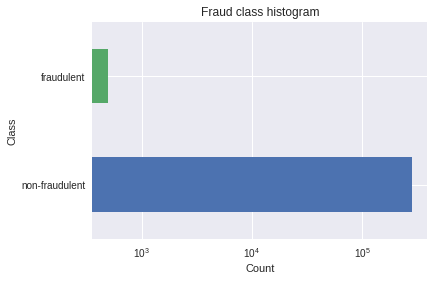

In [60]:
classes_count = pd.value_counts(data['Class'], sort = True).sort_index()
classes_count.plot(kind = 'barh',logx=True,gird)
plt.title("Fraud class histogram")
plt.xlabel("Count")
plt.ylabel("Class")
plt.yticks(ticks=np.arange(2),labels=('non-fraudulent', 'fraudulent'))
classes_count

**Data is clearly imbalanced**

In [55]:
data.shape

(284807, 31)

In [0]:
data = data.drop(['Time'],axis=1)

**Drop dublicate records**

In [0]:
data.drop_duplicates(inplace=True)
data.shape

(275663, 30)

In [0]:
cols=data.columns.tolist()
cols.remove('Class')


In [0]:
data[cols]=preprocessing.StandardScaler().fit_transform(data[cols])

In [0]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.677252,-0.042196,1.665517,0.970648,-0.237760,0.362923,0.186248,0.087610,0.341922,0.080661,...,-0.028490,0.374475,-0.171879,0.121866,0.254403,-0.390126,0.328051,-0.066006,0.233169,0
1,0.629606,0.161091,0.093503,0.317705,0.051286,-0.051899,-0.070455,0.076200,-0.220944,-0.156471,...,-0.311496,-0.887280,0.163479,-0.549879,0.328102,0.260534,-0.027174,0.041547,-0.347092,0
2,-0.676508,-0.802356,1.159302,0.269700,-0.357400,1.381885,0.631175,0.212634,-1.365587,0.188156,...,0.334775,1.054346,1.443271,-1.126933,-0.615882,-0.286812,-0.142731,-0.182341,1.137702,0
3,-0.475699,-0.109639,1.172425,-0.603047,0.000255,0.960554,0.184644,0.321531,-1.249571,-0.053417,...,-0.151250,-0.000762,-0.298328,-1.929997,1.244220,-0.457904,0.151523,0.182036,0.130015,0
4,-0.574014,0.527913,1.010389,0.286026,-0.287736,0.083861,0.471122,-0.222252,0.754566,0.689922,...,-0.016382,1.090965,-0.214613,0.244628,-0.383837,1.037992,0.542031,0.644072,-0.081308,0


## 3.   Training and Testing Data Sets




**Splitting data into train and test data sets from start to avoid test leakage into train set**

The test data set is going to be balanced with equal number of fraud and non-fraud transactions. 

### 3.1 Split Original Data Into Train and Test Data Sets

The test data set  will be used to evaluate all classifiers. Splitting is done at the begining to avoid train test leakge.  

In [0]:
def create_train_test_data(data):
  data1_test=data[data['Class']==1]
  _,data1_test=train_test_split(data1_test,test_size=0.5)
  data0_test=data[data['Class']==0]
  _,data0_test=train_test_split(data0_test,test_size=len(data1_test))
  data_test=pd.concat([data1_test,data0_test])
  data.drop(labels=data_test.index,inplace=True)
  x_test=data_test.drop(labels='Class',axis=1)
  y_test=data_test['Class']
  #as numpy arrays
  x_test=x_test.values
  y_test=y_test.values
  x_original=data.drop(labels='Class',axis=1)
  y_original=data['Class']
  #as numpy arrays
  x_original=x_original.values
  y_original=y_original.values
  x_original,y_original=shuffle(x_original,y_original)
  return x_original,y_original,x_test,y_test

### 3.2 Helper function to create balanced data set

This function is used to create balanced train data set out of the original data set

In [0]:
def create_balanced_data_set(x_original,y_original):
  x_balanced=x_original
  y_balanced=y_original
  x0=x_original[y_original==0]
  x1=x_original[y_original==1]
  y0=y_original[y_original==0]
  y1=y_original[y_original==1]
  q=len(x0)//len(x1)-1
  q=int(q)
  r=len(x0)%len(x1)
  #dum=np.tile(x1,(q,1))
  x_balanced=np.concatenate((x_balanced,np.tile(x1,(q,1))))
  y_balanced=np.concatenate((y_balanced,np.tile(y1,(q,))))
  _,dumx,_,dumy=train_test_split(x1,y1,test_size=r)
  x_balanced=np.concatenate((x_balanced,dumx))
  y_balanced=np.concatenate((y_balanced,dumy))
  x_balanced,y_balanced=shuffle(x_balanced,y_balanced)
  return x_balanced,y_balanced

### 3.3 Helper function to create imbalanced data set

This function is used to create imbalanced train data set out of the original data set. the imbalanced train data set has more fraud transactions than non-fraud ones

In [0]:
def create_imbalanced_data_set(x_balanced,y_balanced,n):
  x_imbalanced=x_balanced
  y_imbalanced=y_balanced
  x0=x_balanced[y_balanced==0]
  x1=x_balanced[y_balanced==1]
  y0=y_balanced[y_balanced==0]
  y1=y_balanced[y_balanced==1]
  x_imbalanced=np.concatenate((x_imbalanced,np.tile(x1,(n,1))))
  y_imbalanced=np.concatenate((y_imbalanced,np.tile(y1,(n,))))
  x_imbalanced,y_imbalanced=shuffle(x_imbalanced,y_imbalanced)
  return x_imbalanced,y_imbalanced

## 4.  MLP Functions

### 4.1 Create MLP

In [0]:
def create_MLP(input_s,output_s,hidden_layers,hidden_size,activation,dropout,learning_rate):
    ml=[]
    layers=[input_s]+hidden_size+[output_s]
    dropout=[0.0]+dropout+[0.0]
    activation=['']+activation+['']
    ml.append(Dense(layers[1],input_shape=[input_s],activation=eval('tf.nn.'+activation[1])))
    for i in range(2,len(layers)-1):
        #print('tf.nn.'+activation[i])
        ml.append(Dense(layers[i],activation=eval('tf.nn.'+activation[i])))
    ml.append(Dense(layers[-1],activation=tf.nn.softmax))
    print(ml)
    model=tf.keras.models.Sequential(ml)
    adam= optimizers.Adam(lr=learning_rate)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

### 4.2 Testing Model by Metric

In [0]:
def test_model_metric(model,features,labels,metric):
    prob=model.predict(features)
    predictions=np.argmax(prob,axis=1)
    met=metric(labels,predictions)
    return met

### 4.3 Training And Saving Model

In [0]:
def train_model_batch_metric(model,epochs,features_train,labels_train,features_valid,labels_valid,batch_size,metric_max,metric,model_path_name,silent=True):
    q=len(features_train)//batch_size
    r=len(features_train)%batch_size
    for i in range(epochs):
      for j in range(q):
        model.train_on_batch(features_train[j*batch_size:(j+1)*batch_size],labels_train[j*batch_size:(j+1)*batch_size],)
        prob=model.predict(features_valid)
        predictions=np.argmax(prob,axis=1)
        met=metric(labels_valid,predictions)
        if met>metric_max:
          if(not silent):
            print(f"*************New Model Saved with correct f1 score of:{met:.5f}***************")
          model.save(model_path_name)
          metric_max= met
      if(r>0):
        model.train_on_batch(features_train[q*batch_size:],labels_train[q*batch_size:])
        prob=model.predict(features_valid)
        predictions=np.argmax(prob,axis=1)
        met=metric(labels_valid,predictions)
        if met>metric_max:
          if(not silent):
            print(f"*************New Model Saved with correct f1 score of:{met:.5f}***************")
          model.save(model_path_name)
          metric_max= met
    model=tf.keras.models.load_model(model_path_name)
    return model,metric_max

In [0]:
def train_model_batch_metric_mod(model,epochs,features_train,labels_train,features_valid,labels_valid,batch_size,metric_max,metric,model_path_name,silent=True):
    backup_model=tf.keras.models.clone_model(model)
    backup_model.set_weights(model.get_weights())
    q=len(features_train)//batch_size
    r=len(features_train)%batch_size
    for i in range(epochs):
      for j in range(q):
        model.train_on_batch(features_train[j*batch_size:(j+1)*batch_size],labels_train[j*batch_size:(j+1)*batch_size],)
        prob=model.predict(features_valid)
        predictions=np.argmax(prob,axis=1)
        met=metric(labels_valid,predictions)
        if met>metric_max:
          if(not silent):
            print(f"*************New Model Saved with correct f1 score of:{met:.5f}***************")
          backup_model.set_weights(model.get_weights())
          metric_max= met
      if(r>0):
        model.train_on_batch(features_train[q*batch_size:],labels_train[q*batch_size:])
        prob=model.predict(features_valid)
        predictions=np.argmax(prob,axis=1)
        met=metric(labels_valid,predictions)
        if met>metric_max:
          if(not silent):
            print(f"*************New Model Saved with correct f1 score of:{met:.5f}***************")
          backup_model.set_weights(model.get_weights())
          metric_max= met
    backup_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return backup_model,metric_max

### 4.4 Create Model

In [0]:
def create_model(input_size, output_classes, hidden_layers, hidden_layers_size,activation, dropout,retrain,learning_rate,model_path):
  if(retrain):
    model = tf.keras.models.load_model(model_path)
    import tensorflow.keras.backend as K
    K.set_value(model.optimizer.lr, learning_rate)
  else:
    model=create_MLP(input_size,output_classes,hidden_layers,hidden_layers_size,activation,dropout,learning_rate)
  return model

##5. Model Parameters

### 5.1 Original Train Data Set Model



In [0]:
#model parameters
input_size=data.shape[1]-1
output_classes=2
hidden_layers=3
hidden_layers_size=[200,200,50]
activation=['tanh','tanh','tanh']
dropout=[0.0,0.0,0.0]
retrain=False
learning_rate=0.00000000000000001
# enter model path and file name where you want to load or save your new model
o_model_path="/content/gdrive/My Drive/Credit Card Fraud/f1_batch_fraud_model_tanh_original.h5"
o_model_par=(input_size, output_classes, hidden_layers, hidden_layers_size,activation, dropout,
                     retrain,learning_rate,o_model_path)

### 5.2 Balanced Train Data Set Model

In [0]:
#model parameters
input_size=data.shape[1]-1
output_classes=2
hidden_layers=3
hidden_layers_size=[200,200,50]
activation=['tanh','tanh','tanh']
dropout=[0.0,0.0,0.0]
retrain=False
learning_rate=0.00000000000000001
# enter model path and file name where you want to load or save your new model
b_model_path=f"/content/gdrive/My Drive/Credit Card Fraud/f1_batch_fraud_model_tanh_balanced.h5"
b_model_par=(input_size, output_classes, hidden_layers, hidden_layers_size,activation, dropout,
                     retrain,learning_rate,b_model_path)

### 5.3 Imbalanced Train Data Set Model

In [0]:
#model parameters
input_size=data.shape[1]-1
output_classes=2
hidden_layers=3
hidden_layers_size=[200,200,50]
activation=['tanh','tanh','tanh']
dropout=[0.0,0.0,0.0]
retrain=False
learning_rate=0.00000000001
# enter model path and file name where you want to load or save your new model
im_model_path="/content/gdrive/My Drive/Credit Card Fraud/f1_fraud_model_tanh_imbalanced.h5"
im_model_par=(input_size, output_classes, hidden_layers, hidden_layers_size,activation, dropout,
                     retrain,learning_rate,im_model_path)

## 6. Training and Testing MLP Models

This section is the core of the note book.  The steps of process are as follows:


1.   Multiple balanced test data sets are  created
2.   For each test data set, original, balanced, and imbalanced train data sets are created.
3.   For each train data set, an MLP model is trained and validated over the test data set for a given metric
4.   I used 4 metrics to run 4 training and testing experiments and models. The used metrics are F1 score, recall score, accuracy score, and area under ROC curve score. 

5.    For each metric, a report is printed to show the performance of validating over this metric for original, balanced, and imbalanced data sets. 



In [0]:
def run_show(data,o_model_par,b_model_par,im_model_par,n_valid,epochs,batch_size,output,metric):
  keys=list(output.keys())
  keys.remove('Data')
  for i in range(n_valid):
    print(f"Iteration {i+1} out of {n_valid}")
    x_original,y_original,x_test,y_test=create_train_test_data(data.copy())
    x_balanced,y_balanced=create_balanced_data_set(x_original,y_original)
    x_imbalanced,y_imbalanced=create_imbalanced_data_set(x_balanced, y_balanced, 5)
    data_sets=[(x_original,y_original),(x_balanced,y_balanced),(x_imbalanced,y_imbalanced)]
    o_model=create_model(*o_model_par)
    b_model=create_model(*b_model_par)
    im_model=create_model(*im_model_par)
    models=[o_model,b_model,im_model]
    models_par=[o_model_par,b_model_par,im_model_par]
    output['Data'].append(y_test)
    for key,model,model_par,data_set in zip(keys,models,models_par,data_sets):
      met_max=test_model_metric(model,*data_set,metric)
      model,met_max=train_model_batch_metric(model,epochs,*data_set,x_test,y_test,batch_size,met_max,metric,model_par[-1]+"_iteration_"+str(i))
      predictions=model.predict(x_test)
      output[key].append(predictions)

In [0]:
def calc_metrics(output):
  Data=output['Data']
  keys=list(output.keys())
  keys.remove('Data')
  results=dict()
  for key in keys:
    results[key]=list()
  for it,data in enumerate(Data,start=0):
    for key in keys:
      pred=output[key][it]
      pred=np.argmax(pred,axis=1)
      acs=accuracy_score(data,pred)
      fs=f1_score(data,pred)
      rs=recall_score(data,pred)
      rocs=roc_auc_score(data,pred)
      fpr, tpr, th = roc_curve(data, pred)
      conf=confusion_matrix(data,pred)
      results[key].append([acs,fs,rs,conf,rocs,fpr,tpr,th])
  return results
      

In [0]:
def print_report(results,metric):
  print('-'*100)
  print (str(metric.__name__))
  print('-'*100)
  f1_sc=[]
  recall_sc=[]
  accuracy_sc=[]
  conf_matrix=[]
  roc_sc=[]
  for key in (results.keys()):
    f1_sc.append([])
    recall_sc.append([])
    accuracy_sc.append([])
    conf_matrix.append([])
    roc_sc.append([])

  for i,item in enumerate(list(results.keys()),start=0):
    for j in range(len(results[item])):

      f1_sc[i].append(results[item][j][1])
      recall_sc[i].append(results[item][j][2])
      accuracy_sc[i].append(results[item][j][0])
      conf_matrix[i].append(results[item][j][3])
      roc_sc[i].append(results[item][j][4])
  for it,key in enumerate(results.keys(),start=0):
    print('-'*100)
    print (key+' Data')
    print('-'*100)
    print(f"Average Accuracy Score: {np.mean(accuracy_sc[it])} +/- ({np.std(accuracy_sc[it])}) ")
    print(f"Average Recall Score: {np.mean(recall_sc[it])} +/- ({np.std(recall_sc[it])}) ")
    print(f"Average F1 Score: {np.mean(f1_sc[it])} +/- ({np.std(f1_sc[it])}) ")
    print(f"Average ROC_AUC Score: {np.mean(roc_sc[it])} +/- ({np.std(roc_sc[it])}) ")
    f, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(np.sum(conf_matrix[it],axis=0), annot = True, linewidths = 0.5, color = "red", fmt = ".0f", ax=ax)
    plt.xlabel("y_predicted")
    plt.ylabel("y_true")
    plt.title("Accumulated Confusion Matrix")
    plt.show()


10 test data sets and train each model for 10 epochs with batch size of 50000 samples. 

In [0]:
validation_tests=10
epochs=10
batch_size=50000

### 6.1 F1 Score

In [0]:
metric=f1_score

In [0]:
output={'Original':[],'Balanced':[],'Imbalanced':[],'Data':[]}
run_show(data,o_model_par,b_model_par,im_model_par,validation_tests,epochs,batch_size,output,metric)
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","wb")
pickle.dump(output,f)
f.close()

In [0]:
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","rb")
output=pickle.load(f)
f.close()

In [0]:
results=calc_metrics(output)

----------------------------------------------------------------------------------------------------
f1_score
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Original Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9067510548523205 +/- (0.012474046834678907) 
Average Recall Score: 0.8261603375527427 +/- (0.024948093669357786) 
Average F1 Score: 0.8984148326527006 +/- (0.014564068918903682) 
Average ROC_AUC Score: 0.9067510548523205 +/- (0.012474046834678863) 


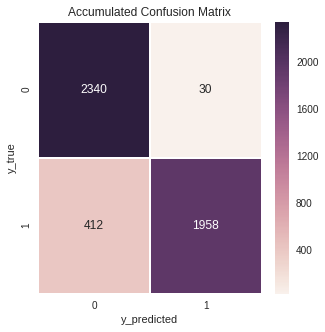

----------------------------------------------------------------------------------------------------
Balanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9470464135021096 +/- (0.008140836025980895) 
Average Recall Score: 0.9181434599156117 +/- (0.013763296565654108) 
Average F1 Score: 0.9454929775495948 +/- (0.00818428729220874) 
Average ROC_AUC Score: 0.9470464135021096 +/- (0.008140836025980912) 


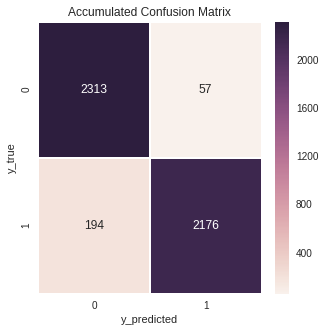

----------------------------------------------------------------------------------------------------
Imbalanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9455696202531645 +/- (0.006855728611507152) 
Average Recall Score: 0.9223628691983123 +/- (0.018216905607529886) 
Average F1 Score: 0.9442288262102126 +/- (0.0073179415576393805) 
Average ROC_AUC Score: 0.9455696202531645 +/- (0.006855728611507129) 


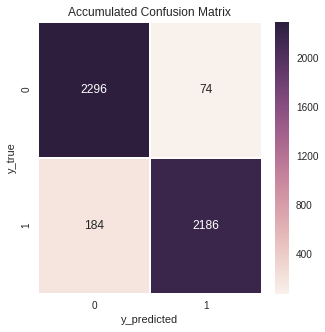

In [0]:
print_report(results,metric)

### 6.2 Recall  Score

In [0]:
metric=recall_score

In [0]:
output={'Original':[],'Balanced':[],'Imbalanced':[],'Data':[]}
run_show(data,o_model_par,b_model_par,im_model_par,validation_tests,epochs,batch_size,output,metric)
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","wb")
pickle.dump(output,f)
f.close()

In [0]:
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","rb")
output=pickle.load(f)
f.close()

In [0]:
results=calc_metrics(output)

----------------------------------------------------------------------------------------------------
recall_score
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Original Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.8559071729957806 +/- (0.036063609802708244) 
Average Recall Score: 0.8780590717299578 +/- (0.04101517590508102) 
Average F1 Score: 0.8604803710706053 +/- (0.027266127497901776) 
Average ROC_AUC Score: 0.8559071729957806 +/- (0.03606360980270824) 


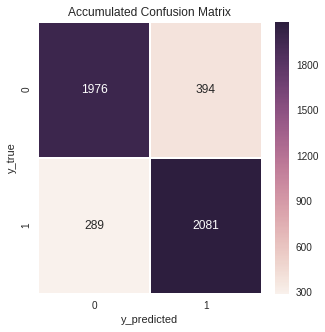

----------------------------------------------------------------------------------------------------
Balanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.8626582278481013 +/- (0.026559664883996553) 
Average Recall Score: 0.9687763713080167 +/- (0.010020541845601626) 
Average F1 Score: 0.876344182619172 +/- (0.02130596473133332) 
Average ROC_AUC Score: 0.8626582278481013 +/- (0.026559664883996543) 


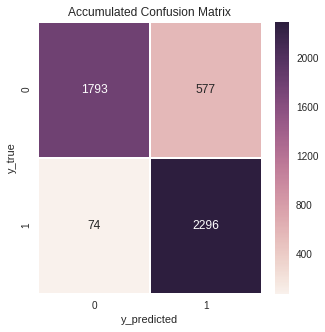

----------------------------------------------------------------------------------------------------
Imbalanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.778902953586498 +/- (0.03379217392434754) 
Average Recall Score: 0.9835443037974683 +/- (0.009330525058015182) 
Average F1 Score: 0.8170864541283092 +/- (0.02347924228142077) 
Average ROC_AUC Score: 0.778902953586498 +/- (0.03379217392434756) 


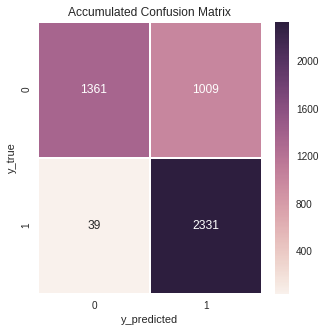

In [0]:
print_report(results,metric)

### 6.3 Accuracy Score

In [0]:
metric=accuracy_score

In [0]:
output={'Original':[],'Balanced':[],'Imbalanced':[],'Data':[]}
run_show(data,o_model_par,b_model_par,im_model_par,validation_tests,epochs,batch_size,output,metric)
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","wb")
pickle.dump(output,f)
f.close()

In [0]:
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","rb")
output=pickle.load(f)
f.close()

In [0]:
results=calc_metrics(output)

----------------------------------------------------------------------------------------------------
accuracy_score
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Original Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9040084388185654 +/- (0.009061912065364755) 
Average Recall Score: 0.819831223628692 +/- (0.013482316716177604) 
Average F1 Score: 0.8951606738154231 +/- (0.010083983516504512) 
Average ROC_AUC Score: 0.9040084388185653 +/- (0.009061912065364821) 


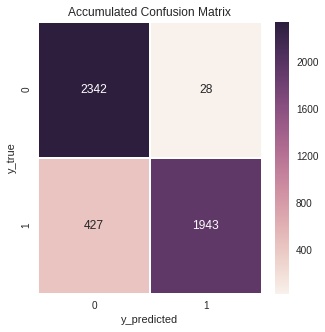

----------------------------------------------------------------------------------------------------
Balanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9447257383966244 +/- (0.005876957078980613) 
Average Recall Score: 0.9164556962025315 +/- (0.012199858476625301) 
Average F1 Score: 0.9431016160234782 +/- (0.006208598250566362) 
Average ROC_AUC Score: 0.9447257383966244 +/- (0.0058769570789806306) 


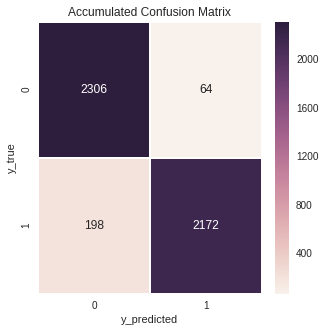

----------------------------------------------------------------------------------------------------
Imbalanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9468354430379747 +/- (0.006454455080497194) 
Average Recall Score: 0.9202531645569622 +/- (0.01405132979354153) 
Average F1 Score: 0.9453558616006619 +/- (0.006791478361625658) 
Average ROC_AUC Score: 0.9468354430379747 +/- (0.006454455080497201) 


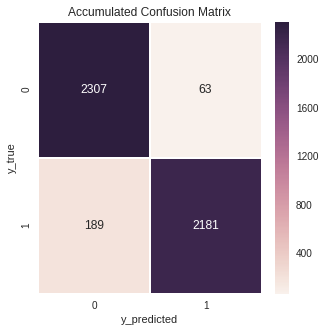

In [0]:
print_report(results,metric)

### 6.4 Area Under ROC Curve Score

In [0]:
metric=roc_auc_score

In [0]:
output={'Original':[],'Balanced':[],'Imbalanced':[],'Data':[]}
run_show(data,o_model_par,b_model_par,im_model_par,validation_tests,epochs,batch_size,output,metric)
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","wb")
pickle.dump(output,f)
f.close()

In [0]:
f = open(f"/content/gdrive/My Drive/Credit Card Fraud/output_{str(metric.__name__)}.pkl","rb")
output=pickle.load(f)
f.close()

In [0]:
results=calc_metrics(output)

----------------------------------------------------------------------------------------------------
roc_auc_score
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Original Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.8981012658227849 +/- (0.010031640023602328) 
Average Recall Score: 0.8012658227848102 +/- (0.01946881349377101) 
Average F1 Score: 0.8870534328369842 +/- (0.012343446263050986) 
Average ROC_AUC Score: 0.8981012658227849 +/- (0.010031640023602323) 


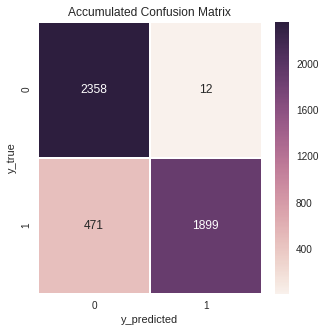

----------------------------------------------------------------------------------------------------
Balanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9462025316455696 +/- (0.010474423280427338) 
Average Recall Score: 0.9147679324894515 +/- (0.019038842485533287) 
Average F1 Score: 0.9443600060694222 +/- (0.011378938893406295) 
Average ROC_AUC Score: 0.9462025316455696 +/- (0.010474423280427362) 


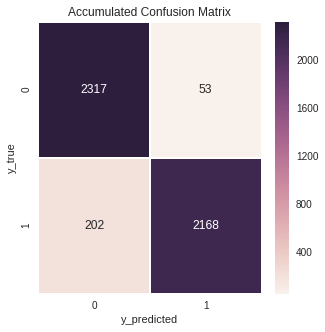

----------------------------------------------------------------------------------------------------
Imbalanced Data
----------------------------------------------------------------------------------------------------
Average Accuracy Score: 0.9436708860759493 +/- (0.009437244407740525) 
Average Recall Score: 0.9126582278481011 +/- (0.0240210047721355) 
Average F1 Score: 0.9417460619045526 +/- (0.010421269628736204) 
Average ROC_AUC Score: 0.9436708860759493 +/- (0.009437244407740538) 


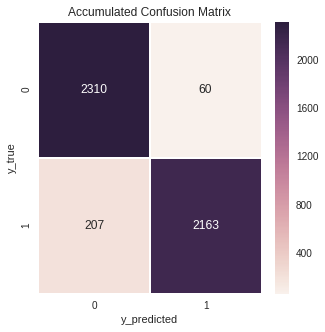

In [0]:
print_report(results,metric)

##7. Conclusion

For this dataset,  MLP classifiers are developed to achieve fruad credit card transactions  detection.

The original data set is imbalanced with more non-fraudulent transactions.  I trained three different MLPs over original, balanced, and imbalanced train data sets. All three models are tested over the exact test data sets to avoid data leakage. To achieve robust measurements, the whole training and testing process is repeated multiple times over multiple test/train data sets.  

Results shows that balanced and imbalanced train data sets are more efficient in terms of fraudulent transactions detection. Moreover, models that are trained to maximize recall score or F1 score are the best among the used metrics (F1 score, recall score, accuracy score, and area under ROC curve) 

In particular, there is a trade off between models trained to maximize recall score and F1 score. Recall score based MLP classifiers are getting most of the true positives however getting more false positives as well. Training over F1 score reduces both true positives and false positives as well. Both models are fine but usage might be subject to credit card cmpany bojective. More sophisticated models can be trained on multiple metrics requirments. 